In [2]:
import pymysql
import tensorflow as tf
from sqlalchemy import create_engine
import pandas as pd

# GPU 설정
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU 설정 완료:", gpus[0])
    except RuntimeError as e:
        print(e)

# 데이터베이스 연결 함수
def get_db():
    db = pymysql.connect(
        host='human-mysql.mysql.database.azure.com',  # Azure MySQL Host
        port=3306,  # Port number (MySQL default is 3306)
        user='human',  # Username
        passwd='!q1w2e3r4',  # Password
        db='humandb',  # Database name
        ssl_ca=r'/home/azureuser/Desktop/config/DigiCertGlobalRootG2.crt.pem'  # SSL certificate path
    )
    return db

# DB에서 데이터 로드
db_connection = get_db()
cursor = db_connection.cursor()

query = "SELECT * FROM humandb.modeling_final"
cursor.execute(query)
columns = [desc[0] for desc in cursor.description]  # 컬럼 이름 가져오기
all_data = cursor.fetchall()  # 데이터 가져오기

# Pandas DataFrame으로 변환
df = pd.DataFrame(all_data, columns=columns)

# 데이터 확인
print("데이터셋의 크기:", df.shape)
print("컬럼명:", df.columns)

2025-02-26 05:28:29.194274: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 05:28:29.197389: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-26 05:28:29.207197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740547709.219127  991726 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740547709.222635  991726 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 05:28:29.235363: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

데이터셋의 크기: (57739, 17)
컬럼명: Index(['Index', 'HeartRate', 'BreathRate', 'SPO2', 'SkinTemperature',
       'SleepPhase', 'SleepScore', 'WalkingSteps', 'StressIndex',
       'ActivityIntensity', 'CaloricExpenditure', '심박', '호흡', '피부온도', '혈중산소농도',
       '일상', '상태'],
      dtype='object')


In [3]:
# 다중 라벨 컬럼 선택
y = df[['상태']]  # 다중 라벨 대상

# 입력 데이터(X) 설정
x = df.drop(columns=['Index', '심박', '호흡', '피부온도', '혈중산소농도','일상','상태'])  # 독립 변수


# 데이터의 shape 확인
print("x (입력 데이터) shape:", x.shape)
print("y (출력 데이터) shape:", y.shape)

x (입력 데이터) shape: (57739, 10)
y (출력 데이터) shape: (57739, 1)


In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# XGBoost에서 사용할 데이터 형식으로 변환
x_train, x_val, x_test = x_train.values, x_val.values, x_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values

In [16]:
# XGBoost DMatrix 변환
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)

# 평가용 데이터 설정
watchlist = [(dtrain, "train"), (dval, "val")]

# 하이퍼파라미터 설정
params = {
    "objective": "multi:softprob",  
    "num_class": 3,  
    "eval_metric": "mlogloss",
    "learning_rate": 0.02,  
    "max_depth": 4,  
    "subsample": 0.7,  
    "colsample_bytree": 0.7,  
    "random_state": 42
}

# 모델 학습 시 evals_result 저장
results = {}

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=50,
    evals=watchlist,
    early_stopping_rounds=10,
    evals_result=results  # 🔥 evals_result 저장!
)



[0]	train-mlogloss:1.07208	val-mlogloss:1.07206
[1]	train-mlogloss:1.04749	val-mlogloss:1.04744
[2]	train-mlogloss:1.02123	val-mlogloss:1.02117
[3]	train-mlogloss:0.99825	val-mlogloss:0.99820
[4]	train-mlogloss:0.97274	val-mlogloss:0.97267
[5]	train-mlogloss:0.94826	val-mlogloss:0.94817
[6]	train-mlogloss:0.92561	val-mlogloss:0.92553
[7]	train-mlogloss:0.90283	val-mlogloss:0.90276
[8]	train-mlogloss:0.88037	val-mlogloss:0.88029
[9]	train-mlogloss:0.86108	val-mlogloss:0.86100
[10]	train-mlogloss:0.84114	val-mlogloss:0.84107
[11]	train-mlogloss:0.82149	val-mlogloss:0.82142
[12]	train-mlogloss:0.80155	val-mlogloss:0.80147
[13]	train-mlogloss:0.78415	val-mlogloss:0.78409
[14]	train-mlogloss:0.76575	val-mlogloss:0.76570
[15]	train-mlogloss:0.74804	val-mlogloss:0.74799
[16]	train-mlogloss:0.73092	val-mlogloss:0.73087
[17]	train-mlogloss:0.71378	val-mlogloss:0.71371
[18]	train-mlogloss:0.69737	val-mlogloss:0.69730
[19]	train-mlogloss:0.68201	val-mlogloss:0.68194
[20]	train-mlogloss:0.66621	va

In [17]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
import numpy as np

# 예측 확률값 (multi:softprob 사용 시 필요)
y_pred_probs = xgb_model.predict(dtest)  # ✅ 확률값 반환 (softmax 사용)
y_pred = np.argmax(y_pred_probs, axis=1)  # ✅ 가장 높은 확률을 가진 클래스로 변환

# AUROC 계산 (다중 클래스의 경우 One-vs-Rest 방식 사용)
auroc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")  

# Log Loss 계산
logloss = log_loss(y_test, y_pred_probs)

# Accuracy 계산
accuracy = accuracy_score(y_test, y_pred)

# 결과 출력
print(f"AUROC Score: {auroc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUROC Score: 0.9999
Log Loss: 0.3641
Accuracy: 0.9998

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7243
           1       1.00      1.00      1.00      3669
           2       1.00      1.00      1.00       636

    accuracy                           1.00     11548
   macro avg       1.00      1.00      1.00     11548
weighted avg       1.00      1.00      1.00     11548



## 과적합(Overfitting)이 발생하는지 확인하는 방법:

### Train Loss vs Validation Loss 차이가 증가하는가?

현재까지는 비슷하게 감소하고 있어 과적합이 심각하지 않음.
그러나 학습이 계속 진행되면 과적합이 발생할 수도 있음.

### Train 정확도와 Test 정확도의 차이가 큰가?

Train: 99%, Test: 99% → 차이가 거의 없음.
그러나 데이터셋이 불균형한 경우 특정 클래스에서만 높은 성능을 보일 수 있음.

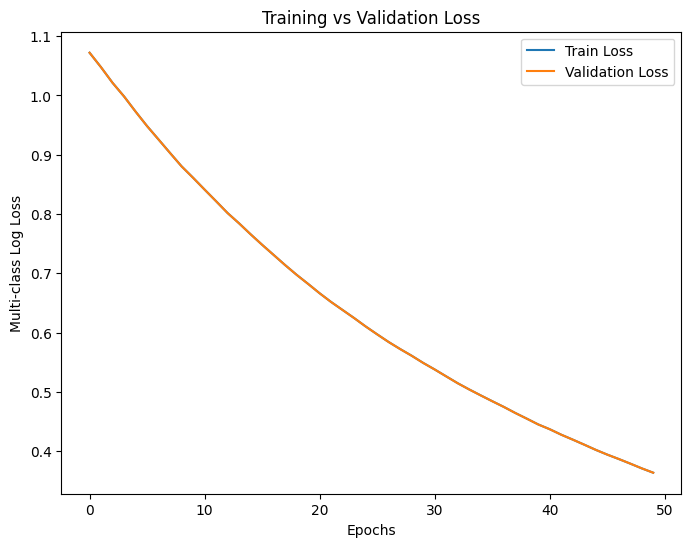

In [18]:
import matplotlib.pyplot as plt

train_loss = results['train']['mlogloss']
val_loss = results['val']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Multi-class Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [19]:
# 상태(Status) 값이 1 또는 2인 데이터만 필터링
df_filtered = df[df["상태"].isin([1, 2])]

# ✅ 필터링된 데이터 출력
from IPython.display import display
display(df_filtered)

,Index,HeartRate,BreathRate,SPO2,SkinTemperature,SleepPhase,SleepScore,WalkingSteps,StressIndex,ActivityIntensity,CaloricExpenditure,심박,호흡,피부온도,혈중산소농도,일상,상태
36213,356,80,24,98,-1.1,1,72,0,0,0,0,1,1,0,0,0,1
36214,357,77,21,97,0.2,1,72,0,0,0,0,1,1,0,0,0,1
36215,358,77,19,98,0.4,0,72,0,0,0,0,1,0,0,0,0,1
36216,359,75,21,98,0.5,0,72,0,0,0,0,1,1,0,0,0,1
36217,360,77,13,98,0.5,2,72,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57734,42949687163,86,22,98,-2.6,0,42,82,0,159,49,0,0,1,0,0,2
57735,42949687247,93,25,98,0.2,0,43,0,0,0,0,0,1,0,0,0,2
57736,51539607860,78,25,98,-1.3,1,12,0,0,0,0,0,1,0,0,0,2
57737,51539607862,76,25,98,-1.1,1,12,0,0,0,0,0,1,0,0,0,2


In [20]:
# 다중 라벨 컬럼 선택
y = df_filtered[['심박', '호흡', '피부온도', '혈중산소농도']]  # 다중 라벨 대상

# 입력 데이터(X) 설정
x = df_filtered.drop(columns=['Index', '심박', '호흡', '피부온도', '혈중산소농도','일상'])  # 독립 변수


# 데이터의 shape 확인
print("x (입력 데이터) shape:", x.shape)
print("y (출력 데이터) shape:", y.shape)

x (입력 데이터) shape: (21526, 11)
y (출력 데이터) shape: (21526, 4)


In [21]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# XGBoost에서 사용할 데이터 형식으로 변환
x_train, x_val, x_test = x_train.values, x_val.values, x_test.values
y_train, y_val, y_test = y_train.values, y_val.values, y_test.values


In [22]:
from xgboost import DMatrix

models = []
with tf.device("GPU:0"):  #GPU 사용
    for i in range(y_train.shape[1]):  # 각 라벨별 개별 모델 학습
        print(f"Training XGBoost Model for Label {i+1}...")

        # DMatrix 변환
        dtrain = DMatrix(x_train, label=y_train[:, i])
        dval = DMatrix(x_val, label=y_val[:, i])

        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "learning_rate": 0.015,  # 0.02 → 0.015
            "max_depth": 4,  #  6 → 4
            "subsample": 0.7,  # 0.8 → 0.7
            "colsample_bytree": 0.7,  #  0.8 → 0.7
            "random_state": 42,
            "tree_method": "hist",
            "device": "cuda"  # GPU 가속
        }

        watchlist = [(dtrain, "train"), (dval, "val")]

        # XGBoost Booster 모델 학습
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=100,
            evals=watchlist,
            early_stopping_rounds=3  # 조기 종료 설정
        )

        models.append(model)

#  모델 학습 완료
print("\n모든 라벨에 대한 XGBoost 모델 학습 완료 ")


Training XGBoost Model for Label 1...
[0]	train-logloss:0.63085	val-logloss:0.63674
[1]	train-logloss:0.61694	val-logloss:0.62268
[2]	train-logloss:0.61425	val-logloss:0.62015
[3]	train-logloss:0.60183	val-logloss:0.60760
[4]	train-logloss:0.59818	val-logloss:0.60378
[5]	train-logloss:0.59277	val-logloss:0.59844
[6]	train-logloss:0.58011	val-logloss:0.58564
[7]	train-logloss:0.56780	val-logloss:0.57322
[8]	train-logloss:0.55804	val-logloss:0.56334
[9]	train-logloss:0.54738	val-logloss:0.55258
[10]	train-logloss:0.53613	val-logloss:0.54123
[11]	train-logloss:0.53297	val-logloss:0.53808
[12]	train-logloss:0.52412	val-logloss:0.52914
[13]	train-logloss:0.52127	val-logloss:0.52617
[14]	train-logloss:0.51166	val-logloss:0.51648
[15]	train-logloss:0.51048	val-logloss:0.51541
[16]	train-logloss:0.50587	val-logloss:0.51077
[17]	train-logloss:0.50138	val-logloss:0.50625
[18]	train-logloss:0.49144	val-logloss:0.49623
[19]	train-logloss:0.48177	val-logloss:0.48647
[20]	train-logloss:0.47798	val-l

In [ ]:
from sklearn.metrics import hamming_loss, f1_score, jaccard_score

# 모든 모델(4개)에서 예측 수행
y_pred_probs = np.array([model.predict(DMatrix(x_test)) for model in models]).T  # (샘플 개수, 라벨 개수) 형태 변환
y_pred = (y_pred_probs > 0.5).astype(int)  # 확률값을 0 또는 1로 변환

# Hamming Loss (낮을수록 좋음)
hamming = hamming_loss(y_test, y_pred)

# Micro F1-Score (전체 샘플 기반)
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Macro F1-Score (각 클래스별 평균)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Jaccard Score (Intersection over Union)
jaccard = jaccard_score(y_test, y_pred, average='samples')

# 결과 출력
print(f"Hamming Loss: {hamming:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Jaccard Score: {jaccard:.4f}")


Hamming Loss: 0.0051
Micro F1-Score: 0.9921
Macro F1-Score: 0.9744
Jaccard Score: 0.9907


In [24]:
# x_test를 DMatrix로 변환
dtest = DMatrix(x_test)

# 다중 라벨 예측 수행
y_pred_probs = np.zeros((x_test.shape[0], len(models)))  # (샘플 수, 라벨 수) 크기의 확률값 배열
for i, model in enumerate(models):
    y_pred_probs[:, i] = model.predict(dtest)  # ✅ 개별 모델 사용

# 확률값을 0.5 기준으로 이진화
y_pred_binary = np.round(y_pred_probs).astype(int)

# 정확도 평가
accuracies = []
for i in range(y_test.shape[1]):
    acc = accuracy_score(y_test[:, i], y_pred_binary[:, i])
    accuracies.append(acc)
    print(f"라벨 {i+1} 정확도: {acc:.4f}")

# 전체 평균 정확도
overall_accuracy = np.mean(accuracies)
print(f"\n전체 평균 정확도: {overall_accuracy:.4f}")


라벨 1 정확도: 0.9956
라벨 2 정확도: 0.9965
라벨 3 정확도: 0.9937
라벨 4 정확도: 0.9937

전체 평균 정확도: 0.9949
